We implement AlexNet from the original [paper](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

### Dataset
The goal is to train AlexNet on a subset of ImageNet ([ImageNet-100](https://www.kaggle.com/datasets/ambityga/imagenet100)). Images have high resolution and for our training, we used 224x224 images.

AlexNet achieved excellent performance in the 2012 ImageNet challenge. For high performance on very large dataset, larger model are needed and AlexNet made a significant a improvement over LeNet. Hardware improvements also made it successfull.

<p align="center">
  <img src="alexnet-model.png" alt="AlexNet" width="70%">
</p>

In [30]:
import numpy as np
import torchvision

import dataset

In [31]:
batch_size = 128

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256),
    torchvision.transforms.CenterCrop(size=256),
    torchvision.transforms.ToTensor()
])
data = dataset.ImageNet100(batch_size=batch_size, transforms=transforms, num_labels=10)
num_classes = data.num_classes

For computational purpose, I made a second training on 10 labels. I fact, GoogLeNet model was hard to tune and took so much time to converge. Thus to compare all architectures, i had to make second trainings. See [main-100.ipynb](main-100.ipynb) for the training of the full dataset for AlexNet architecture.

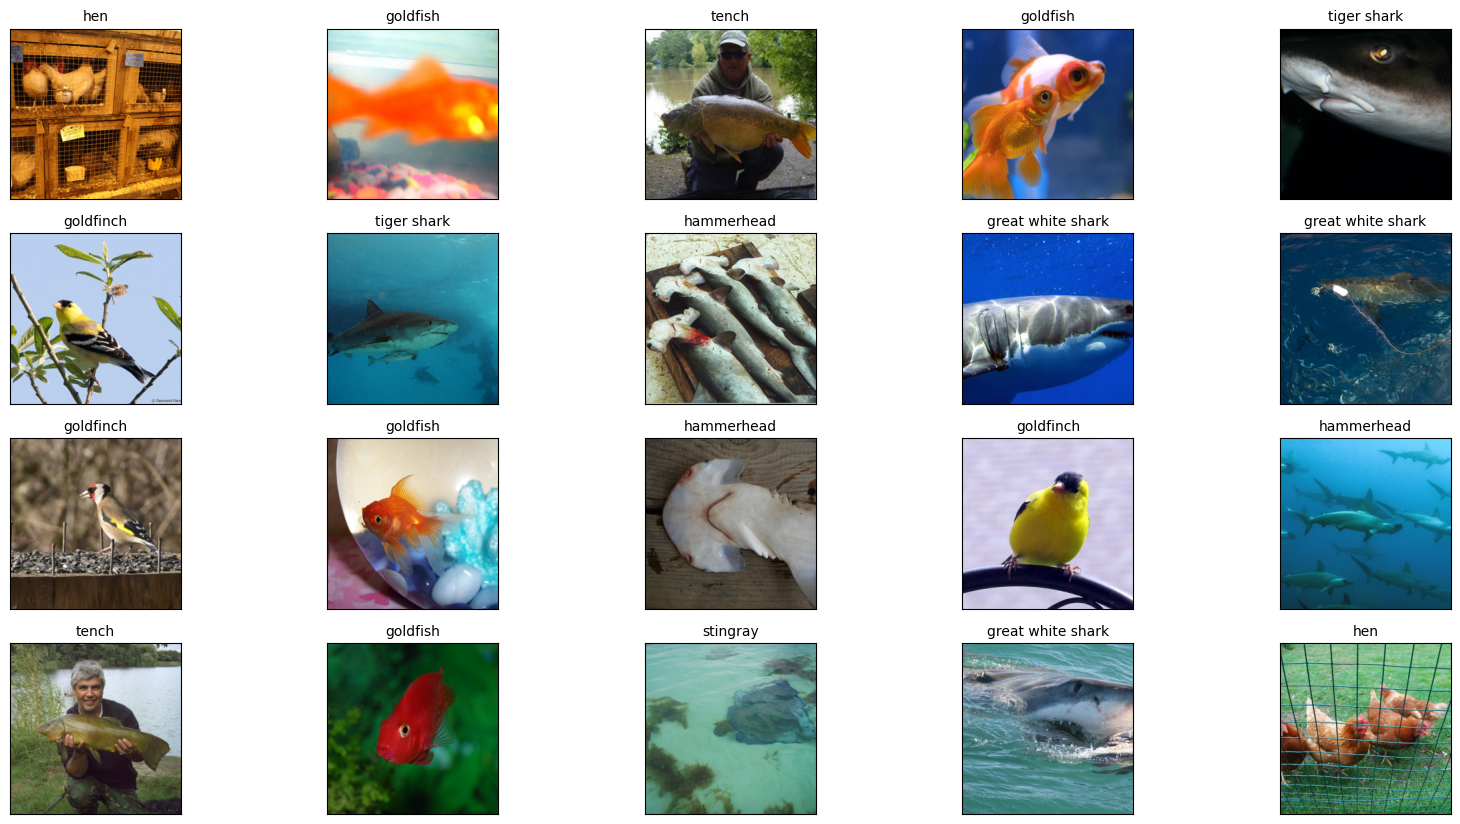

torch.Size([128, 3, 256, 256])


In [32]:
for batch in data.train_dataloader:
    x, y = batch
    labels = [data.labels_idx2str[yi] for yi in y.numpy()]
    data.show_images(x.permute(0,2,3,1)[:20], labels)
    print(x.shape); break

In [33]:
for v in data.labels.values():
    print(v[0])

tench, Tinca tinca
goldfish, Carassius auratus
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
tiger shark, Galeocerdo cuvieri
hammerhead, hammerhead shark
electric ray, crampfish, numbfish, torpedo
stingray
cock
hen
goldfinch, Carduelis carduelis


### Model

In [34]:
import model

In [35]:
alexnet = model.AlexNet(num_classes=num_classes)
alexnet

AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=9216, out_features=4096, bias=True

AlexNet is composed of eight learned layers: five convolutionnal layers and three fully-connected. The network architecture is given in the scheme below.

### Activation
AlexNet use ReLU as activation function in all the convolutional and fully-connected layers instead of Sigmoid.

$ReLU(x)=\max(x,0)$ is a saturating nonlinearity activation function and fast to compute. Plus the Sigmoid was prone to vanishing gradients.

In [36]:
def compute_number_params(model):
    num_total_params = 0
    for _, params in model.named_parameters():
        if params.requires_grad:
            num_total_params += params.numel()
    return num_total_params

In [37]:
print("Number of parameters of AlexNet:", compute_number_params(alexnet))

Number of parameters of AlexNet: 58321834


### Local Response Normalization

AlexNet used local response normalization in order to help for generalization. Even if it is no longer used in modern architecures, the layer is applied after the ReLU and normalize across channels.

The response-normalized activity $b_{x,y}^i$ is given:

$$b_{x,y}^i = a_{x,y}^i \left(k + \alpha \sum_{j=\max(0, i-n/2)}^{\min(N-1,i+n/2)} (a_{x,y}^j)^2\right)^\beta$$

where:
- the sum runs over $n$ "adjacent" kernel maps at the same spatial position $(x,y)$
- $N$ is the total number of kernels in the layer
- the order of kernel maps is arbitrary
- the contants are: $k=2$, $n=5$, $\alpha=10^{-4}$ and $\beta=0.75$

This layer is effective as it helps to reduce the top-1 and top-5 errors

### Architecture

In [38]:
alexnet

AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=9216, out_features=4096, bias=True

The two first convolutional layers are followed by local response normalization and max-pooling. ReLU activations were used for all convolutional and fully connected layers. Dropout is used in the first two fully-connected layers. It helps to fight againts overfitting and forces the network to learn more robust features.

Each learnable weight of the network is initialized with zero-mean Gaussian distribution with standard deviation of $0.01$. For biases, neurons in the 2nd, 4th and 5th convolutional layers and in fully-connected layers are initialized to $1$. For the rest, the initial bias is $0$.

### Training

Data augmentation was used. We used the first form presented in the paper. As the ImageNet-100 dataset have not fixed-size images, we reshaped the images to 2X6x256 and made random extraction of 224x224 patches. We enable a random horitontal flip of 0.5 probability and normalization accross each RGB channel. Plus we implemented pixel alteration using PCA mentionned in the paper. Actually we used Iterative PCA as the data is very large.

For the training, the setup is:
- Optimizer: SGD + momentum of $0.9$
- Learning rate is initializd at $0.01$ and divided by $10$ when the valdiation loss stop improving. Weight decay of $0.0005$ is applied for regularization
- Loss: CrossEntropy
- Epochs: 90
- Batch size: 64

In [39]:
from PIL import Image
import matplotlib.pyplot as plt
import json

In [40]:
# for metric in ["loss", "accuracy"]:
#     for set_name in ["train", "eval"]:
#         img = Image.open(f"{set_name}-{metric}.png")
#         plt.imshow(img, cmap="gray")
#         plt.axis("off")
#         plt.show()

with open("alexnet.json", "r") as f:
    logs = json.load(f)

In [49]:
logs.keys()

dict_keys(['num_train_batches', 'max_epochs', 'Loss/train', 'Accuracy/train', 'Loss/eval', 'Accuracy/eval'])

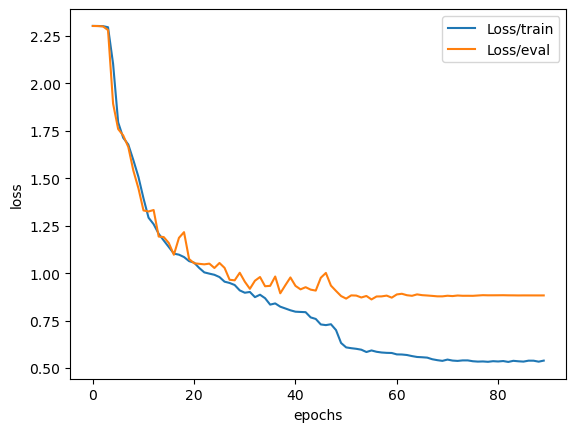

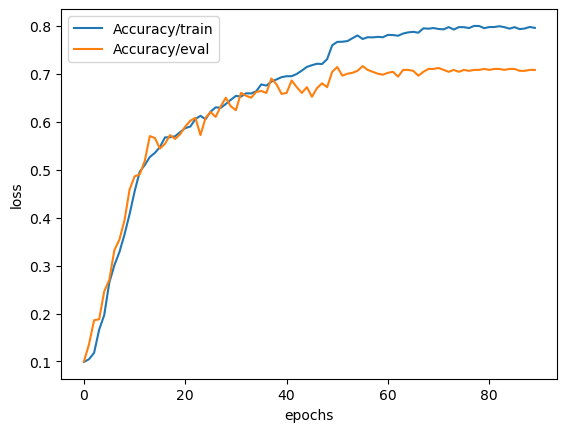

In [ ]:
train_loss = np.array(list(logs["Loss/train"].values()))
eval_loss = np.array(list(logs["Loss/eval"].values()))
train_acc = np.array(list(logs["Accuracy/train"].values()))
eval_acc = np.array(list(logs["Accuracy/eval"].values()))
epochs = np.arange(logs["num_train_batches"]-1, logs["max_epochs"]*logs["num_train_batches"]+logs["num_train_batches"]-1, logs["num_train_batches"])
train_loss_by_epochs = train_loss[epochs]
train_acc_by_epochs = train_acc[epochs]


plt.plot(np.arange(len(train_loss_by_epochs)), train_loss_by_epochs, label="Loss/train")
plt.plot(np.arange(len(eval_loss)), eval_loss, label="Loss    plt.plot(vgg16_metrics[i], label="vgg16")
/eval")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.plot(np.arange(len(train_acc_by_epochs)), train_acc_by_epochs, label="Accuracy/train")
plt.plot(np.arange(len(eval_acc)), eval_acc, label="Accuracy/eval")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

We used only accuracy as metrics because the dataset is balanced. We can see our model overfitted. We should have used the second form of data augmentation mentionned in the paper which tackles altering the intensities of the RGB channems in training images.

However, the main reason of the overfitting may be explained by the fact ImageNet-100 is too small (~130K for training size) and the model is too complex (+58M parameters) for the training set. So it memorized as the model capacity is higher than the data complexity. The architecture was designed to train on +1M of images.

We would like to mention that altering RGB pixel using PCA data augmentation presented in the paper help to improve eval accuracy. We did both training and this augmentation enabled to gain 3% of accuracy on eval set

In [42]:
import torch
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

import dataset

We propose the confusion matrix on the validation dataset used during training.

In [43]:
batch_size = 128
data = dataset.ImageNet100(batch_size=batch_size, num_labels=10)
num_classes = data.num_classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = torch.load("alexnet.pth").to(device)
alexnet.eval()

/tmp/ipykernel_34362/1010197181.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  alexnet = torch.load("alexnet.pth").to(device)


AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=9216, out_features=4096, bias=True

In [44]:
def get_eval_confusion_matrix(model, eval_dataloader):
    all_preds = []
    all_true = []
    for batch in eval_dataloader:
        batch = [a.to(device) for a in batch]
        with torch.no_grad():
            output = model(*batch[:-1])
            pred = output.argmax(dim=-1).detach().cpu().numpy()
            all_preds.append(pred)
            all_true.append(batch[-1].detach().cpu().numpy())

    return confusion_matrix(y_true=np.concatenate(all_true), y_pred=np.concatenate(all_preds))

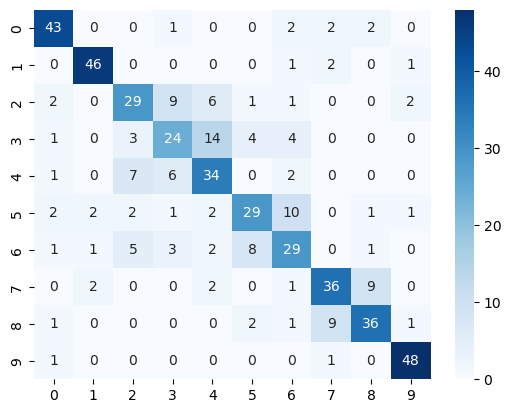

In [45]:
alexnet_eval_cm = get_eval_confusion_matrix(alexnet, data.eval_dataloader)
sns.heatmap(alexnet_eval_cm, cmap="Blues", annot=True); plt.show()

### Topk error

In [46]:
def compute_top_k_error(model, eval_dataloader, k: int=5):
    topk_acc = 0
    num_instances = 0
    for batch in eval_dataloader:
        batch = [a.to(device) for a in batch]
        with torch.no_grad():
            output = model(*batch[:-1])
            _, pred = output.topk(k, dim=1)
            topk_acc += (pred==batch[-1].view(-1, 1).expand_as(pred)).any(dim=-1).float().sum().item()
            num_instances += batch[-1].size(0)
    topk_acc /= num_instances
    return topk_acc, 1-topk_acc

In [47]:
for k in range(1, 6, 2):
    topk_acc, topk_error = compute_top_k_error(model=alexnet, eval_dataloader=data.eval_dataloader, k=k)
    print(f"AlexNet: top{k}_accuracy: {topk_acc:.5f}, top{k}_error: {topk_error:.5f}")

AlexNet: top1_accuracy: 0.70800, top1_error: 0.29200
AlexNet: top3_accuracy: 0.93600, top3_error: 0.06400
AlexNet: top5_accuracy: 0.98600, top5_error: 0.01400
